In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
0    1000015157.jpg
1    1000201771.jpg
2     100042118.jpg
3    1000723321.jpg
4    1000812911.jpg
Name: image_id, dtype: object


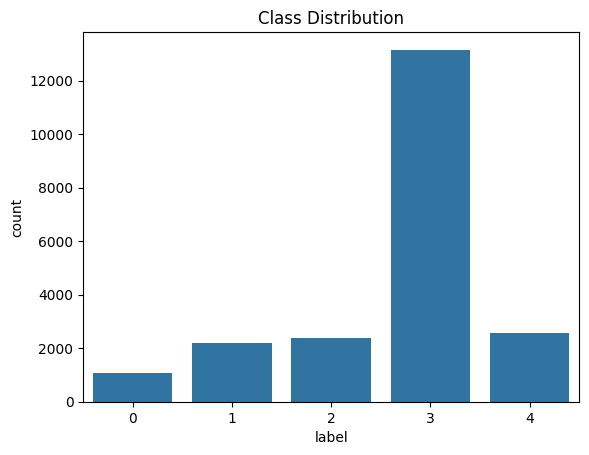

In [40]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
image_folder = os.path.join(dataset_path, "train_images")
csv_file = os.path.join(dataset_path, "train.csv")

# Load CSV file
df = pd.read_csv(csv_file)


# Check the first few rows
print(df.head())

print(df['image_id'].head())  # Check the first few filenames

# Check class distribution
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()


In [41]:

image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

if os.path.exists(image_folder):
    print("Image folder exists")
    print("Sample images in directory:", os.listdir(image_folder)[:10])  # Show first 10 images
else:
    print("Image folder does NOT exist! Check your Google Drive path.")

print(os.listdir(image_folder)[:10])  # Show the first 10 image names


Image folder exists
Sample images in directory: ['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']
['805835204.jpg', '808870213.jpg', '807190211.jpg', '80998969.jpg', '807555228.jpg', '806670613.jpg', '808606006.jpg', '804903970.jpg', '809489252.jpg', '807063038.jpg']


In [42]:


# Define paths
csv_path = "/content/drive/MyDrive/cassava_dataset/train.csv"
image_folder = "/content/drive/MyDrive/cassava_dataset/train_images"

# Load train.csv
df = pd.read_csv(csv_path)

# Get lists of image names
csv_images = set(df['image_id'])  # Images listed in CSV
folder_images = set(os.listdir(image_folder))  # Images in train_images folder

# Identify missing and extra images
missing_images = csv_images - folder_images  # In CSV but not in folder
extra_images = folder_images - csv_images  # In folder but not in CSV

# Print results
print(f"Total images in CSV: {len(csv_images)}")
print(f"Total images in folder: {len(folder_images)}")
print(f"Missing images (in CSV but not in folder): {len(missing_images)}")
print(f"Extra images (in folder but not in CSV): {len(extra_images)}")


Total images in CSV: 21397
Total images in folder: 17938
Missing images (in CSV but not in folder): 3459
Extra images (in folder but not in CSV): 0


In [43]:
# Remove rows in df where images are missing
df = df[~df['image_id'].isin(missing_images)]

# Save cleaned CSV (optional, for future use)
cleaned_csv_path = "/content/drive/MyDrive/cassava_dataset/train_cleaned.csv"
df.to_csv(cleaned_csv_path, index=False)

print(f"Updated dataset size: {len(df)}")


Updated dataset size: 17938


In [44]:
for img in extra_images:
    img_path = os.path.join(image_folder, img)
    os.remove(img_path)  # Delete extra image

print("Extra images removed successfully!")


Extra images removed successfully!


In [45]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32

# Define paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
csv_path = os.path.join(dataset_path, "train.csv")
image_folder = os.path.join(dataset_path, "train_images")

# Load dataset
df = pd.read_csv(csv_path)

# Get actual image filenames from the folder
available_images = set(os.listdir(image_folder))

# Remove rows where images are missing
df = df[df['image_id'].isin(available_images)].reset_index(drop=True)

# Print dataset stats
print(f"Total images in CSV (after cleaning): {len(df)}")
print(f"Total images available in folder: {len(available_images)}")


# Function to preprocess images
def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise Exception("Corrupt Image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # Resize to 224x224
        img = img / 255.0  # Normalize pixel values to [0,1]
        return img
    except:
        print(f"Warning: Could not read image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return blank image

# Split dataset into train, validation, test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)



Total images in CSV (after cleaning): 17938
Total images available in folder: 17938


In [46]:
# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=30,       # Random rotation (0-30 degrees)
    width_shift_range=0.2,   # Horizontal shift (up to 20% of width)
    height_shift_range=0.2,  # Vertical shift (up to 20% of height)
    shear_range=0.2,         # Shearing transformation (distorts shape)
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

#Validation & Test Preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation & test

# Convert 'label' column to string type
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

# Create Data Generators
#train generator(with augumentation)
train_generator = train_datagen.flow_from_dataframe(
    df_train, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Validation Generator-Only rescales images (no augmentation)
val_generator = val_datagen.flow_from_dataframe(
    df_val, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse"
)

#Test Generator (For Final Evaluation)
test_generator = val_datagen.flow_from_dataframe(
    df_test, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    shuffle=False  # No need to shuffle test data
)

# Print dataset sizes
print(f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print(" Data preprocessing & augmentation completed successfully!")


Found 12556 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Found 2691 validated image filenames belonging to 5 classes.
Train size: 12556, Validation size: 2691, Test size: 2691
 Data preprocessing & augmentation completed successfully!


In [47]:
# Define custom CNN model
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(df['label'].unique())):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Create model
model = build_custom_cnn()
model.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save final model
model.save("cassava_custom_cnn.h5")
print("Model saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,213,573 (100.00 MB)

 Trainable params: 26,212,613 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4281 - loss: 10.8929

393/393 ━━━━━━━━━━━━━━━━━━━━ 773s 2s/step - accuracy: 0.4282 - loss: 10.8796 - val_accuracy: 0.6132 - val_loss: 1.4436 - learning_rate: 0.0010
Epoch 2/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5865 - loss: 1.3315

393/393 ━━━━━━━━━━━━━━━━━━━━ 248s 632ms/step - accuracy: 0.5866 - loss: 1.3314 - val_accuracy: 0.6150 - val_loss: 1.1831 - learning_rate: 0.0010
Epoch 3/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6056 - loss: 1.2016

393/393 ━━━━━━━━━━━━━━━━━━━━ 244s 621ms/step - accuracy: 0.6056 - loss: 1.2016 - val_accuracy: 0.6150 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 4/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 243s 618ms/step - accuracy: 0.6183 - loss: 1.1250 - val_accuracy: 0.6150 - val_loss: 1.2410 - learning_rate: 0.0010
Epoch 5/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6100 - loss: 1.0865

393/393 ━━━━━━━━━━━━━━━━━━━━ 244s 620ms/step - accuracy: 0.6101 - loss: 1.0865 - val_accuracy: 0.6150 - val_loss: 1.0300 - learning_rate: 0.0010
Epoch 6/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 242s 614ms/step - accuracy: 0.6154 - loss: 1.0554 - val_accuracy: 0.6150 - val_loss: 1.1137 - learning_rate: 0.0010
Epoch 7/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6104 - loss: 1.0861

393/393 ━━━━━━━━━━━━━━━━━━━━ 243s 618ms/step - accuracy: 0.6104 - loss: 1.0861 - val_accuracy: 0.6150 - val_loss: 1.0254 - learning_rate: 0.0010
Epoch 8/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 245s 622ms/step - accuracy: 0.6214 - loss: 1.0329 - val_accuracy: 0.6139 - val_loss: 1.2209 - learning_rate: 0.0010
Epoch 9/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 243s 618ms/step - accuracy: 0.6167 - loss: 1.0129 - val_accuracy: 0.6150 - val_loss: 1.0605 - learning_rate: 0.0010
Epoch 10/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6164 - loss: 1.0119

393/393 ━━━━━━━━━━━━━━━━━━━━ 243s 618ms/step - accuracy: 0.6164 - loss: 1.0120 - val_accuracy: 0.6150 - val_loss: 1.0134 - learning_rate: 0.0010
Epoch 11/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 237s 604ms/step - accuracy: 0.6074 - loss: 1.0277 - val_accuracy: 0.6150 - val_loss: 1.1714 - learning_rate: 0.0010
Epoch 12/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6194 - loss: 0.9941

393/393 ━━━━━━━━━━━━━━━━━━━━ 244s 620ms/step - accuracy: 0.6194 - loss: 0.9941 - val_accuracy: 0.6150 - val_loss: 1.0055 - learning_rate: 0.0010
Epoch 13/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 239s 608ms/step - accuracy: 0.6107 - loss: 1.0095 - val_accuracy: 0.6150 - val_loss: 1.2884 - learning_rate: 0.0010
Epoch 14/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 238s 607ms/step - accuracy: 0.6153 - loss: 1.0054 - val_accuracy: 0.6150 - val_loss: 1.0627 - learning_rate: 0.0010
Epoch 15/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6177 - loss: 0.9898
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
393/393 ━━━━━━━━━━━━━━━━━━━━ 241s 612ms/step - accuracy: 0.6177 - loss: 0.9898 - val_accuracy: 0.6150 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 16/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.6099 - loss: 0.9504

393/393 ━━━━━━━━━━━━━━━━━━━━ 238s 606ms/step - accuracy: 0.6099 - loss: 0.9503 - val_accuracy: 0.6150 - val_loss: 0.8711 - learning_rate: 2.0000e-04
Epoch 17/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 240s 610ms/step - accuracy: 0.6140 - loss: 0.9113 - val_accuracy: 0.6150 - val_loss: 1.0716 - learning_rate: 2.0000e-04
Epoch 18/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 242s 617ms/step - accuracy: 0.6174 - loss: 0.9044 - val_accuracy: 0.6150 - val_loss: 0.8734 - learning_rate: 2.0000e-04
Epoch 19/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.6130 - loss: 0.9127
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
393/393 ━━━━━━━━━━━━━━━━━━━━ 238s 606ms/step - accuracy: 0.6130 - loss: 0.9127 - val_accuracy: 0.6150 - val_loss: 0.8871 - learning_rate: 2.0000e-04
Epoch 20/20
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6122 - loss: 0.8884

393/393 ━━━━━━━━━━━━━━━━━━━━ 242s 616ms/step - accuracy: 0.6122 - loss: 0.8884 - val_accuracy: 0.6150 - val_loss: 0.8694 - learning_rate: 4.0000e-05
Restoring model weights from the end of the best epoch: 20.
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.6193 - loss: 0.8832


Test Accuracy: 61.46%
Model saved successfully!


In [19]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32

# Define paths
dataset_path = "/content/drive/MyDrive/cassava_dataset"
csv_path = os.path.join(dataset_path, "train.csv")
image_folder = os.path.join(dataset_path, "train_images")

# Load dataset
df = pd.read_csv(csv_path)

# Get actual image filenames from the folder
available_images = set(os.listdir(image_folder))

# Remove rows where images are missing
df = df[df['image_id'].isin(available_images)].reset_index(drop=True)

# Print dataset stats
print(f"Total images in CSV (after cleaning): {len(df)}")
print(f"Total images available in folder: {len(available_images)}")

# Function to preprocess images
def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise Exception("Corrupt Image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # Normalize
        return img
    except:
        print(f"Warning: Could not read image {img_path}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Return blank image

# Function to generate batches of data
class CassavaDataGenerator:
    def __init__(self, df, image_folder, batch_size=BATCH_SIZE):
        self.df = df
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        batch_images = np.array([preprocess_image(os.path.join(self.image_folder, img)) for img in batch_df['image_id']])
        batch_labels = np.array(batch_df['label'])

        return batch_images, batch_labels

# Split dataset into train, validation, test
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

# Create data generators
train_generator = CassavaDataGenerator(df_train, image_folder, BATCH_SIZE)
val_generator = CassavaDataGenerator(df_val, image_folder, BATCH_SIZE)
test_generator = CassavaDataGenerator(df_test, image_folder, BATCH_SIZE)

# Print dataset sizes
print(f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print("Dataset preprocessing completed successfully!")


Total images in CSV (after cleaning): 17938
Total images available in folder: 17938
Train size: 12556, Validation size: 2691, Test size: 2691
Dataset preprocessing completed successfully!


In [29]:

# Import libraries
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
dataset_path = "/content/drive/MyDrive/cassava_dataset"
csv_path = os.path.join(dataset_path, "train.csv")
image_folder = os.path.join(dataset_path, "train_images")

# Load dataset
df = pd.read_csv(csv_path)

# Filter missing images
available_images = set(os.listdir(image_folder))
df = df[df['image_id'].isin(available_images)].reset_index(drop=True)

# Print dataset stats
print(f"Total images in dataset (after cleaning): {len(df)}")

# Data split (train, validation, test)
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

# Define data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create image data generators
train_generator = train_datagen.flow_from_dataframe(
    df_train, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    dtype='float32'
)

val_generator = val_test_datagen.flow_from_dataframe(
    df_val, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse",
    dtype='float32'
)

test_generator = val_test_datagen.flow_from_dataframe(
    df_test, directory=image_folder, x_col="image_id", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False,
    dtype='float32'
)

# Define custom CNN model
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(df['label'].unique())):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Create model
model = build_custom_cnn()
model.summary()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, mode="min"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save final model
model.save("cassava_custom_cnn.h5")
print("Model saved successfully!")




Total images in dataset (after cleaning): 17938


TypeError: If class_mode="sparse", y_col="label" column values must be strings.